In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
#from regions import PolygonSkyRegion
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt


In [2]:

def square_corners(center_ra, center_dec, side_arcsec):
    """
    Return RA/Dec corners of a square centered at (ra, dec)
    with side length in arcseconds.
    """
    half = (side_arcsec / 2.0) / 3600.0  # degrees
    
    # RA correction for cos(dec)
    dra = half / np.cos(np.deg2rad(center_dec))
    ddec = half

    # Four corners (clockwise)
    ra = np.array([center_ra - dra,
                   center_ra + dra,
                   center_ra + dra,
                   center_ra - dra])

    dec = np.array([center_dec - ddec,
                    center_dec - ddec,
                    center_dec + ddec,
                    center_dec + ddec])

    return ra, dec


def plot_square(ax, wcs, center_ra, center_dec, side_arcsec=133,
                color='cyan', lw=2):

    ra, dec = square_corners(center_ra, center_dec, side_arcsec)

    # Convert RA/Dec → pixel coords
    xpix, ypix = wcs.world_to_pixel_values(ra, dec)

    # Close polygon
    xpix = np.append(xpix, xpix[0])
    ypix = np.append(ypix, ypix[0])

    ax.plot(xpix, ypix, color=color, lw=lw)

from astropy.io import fits
from astropy.wcs import WCS
import glob

def get_image_corners_ra_dec(filename):
    """
    Return the RA/Dec corner coordinates of a FITS image as
    [(LL), (LR), (UR), (UL)] in degrees.
    """
    hdu = fits.open(filename)[0]
    wcs = WCS(hdu.header)

    ny, nx = hdu.data.shape

    # pixel corners (x, y)
    pixel_coords = [
        (0,     0),       # lower left
        (nx-1,  0),       # lower right
        (nx-1,  ny-1),    # upper right
        (0,     ny-1),    # upper left
    ]

    xs = [p[0] for p in pixel_coords]
    ys = [p[1] for p in pixel_coords]

    ras, decs = wcs.pixel_to_world_values(xs, ys)

    # pack as list of tuples
    corners = [(float(r), float(d)) for r, d in zip(ras, decs)]
    return corners


def build_corner_dictionary(fits_list):
    """
    Given a list of FITS filenames, return a dict:
       {"filename": [(ra1,dec1), (ra2,dec2), (ra3,dec3), (ra4,dec4)], ...}
    """
    out = {}
    for fname in fits_list:
        out[fname] = get_image_corners_ra_dec(fname)
    return out


In [3]:
import numpy as np

def find_science_bbox(data):
    """
    Return the bounding box of the non-zero or non-NaN region
    in the image: (xmin, xmax, ymin, ymax)
    """
    mask = (data != 0) & (~np.isnan(data))
    ys, xs = np.where(mask)
    xmin = xs.min()
    xmax = xs.max()
    ymin = ys.min()
    ymax = ys.max()
    return xmin, xmax, ymin, ymax

from astropy.io import fits
from astropy.wcs import WCS

def get_science_corners_ra_dec(filename):
    """
    Return the RA/Dec of the corners of the non-zero (science) region
    in a FITS file.
    """
    hdu = fits.open(filename)[0]
    wcs = WCS(hdu.header)
    data = hdu.data

    xmin, xmax, ymin, ymax = find_science_bbox(data)

    # corners of the bbox
    pixel_coords = [
        (xmin, ymin),  # lower left
        (xmax, ymin),  # lower right
        (xmax, ymax),  # upper right
        (xmin, ymax),  # upper left
    ]

    xs = [p[0] for p in pixel_coords]
    ys = [p[1] for p in pixel_coords]

    ras, decs = wcs.pixel_to_world_values(xs, ys)
    corners = [(float(r), float(d)) for r, d in zip(ras, decs)]
    return corners

def build_science_corner_dictionary(fits_list):
    out = {}
    for fname in fits_list:
        out[fname] = get_science_corners_ra_dec(fname)
    return out


In [4]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

def get_science_edges(filename):
    """
    Returns the RA/Dec of the left-most, right-most,
    upper-most, and lower-most non-zero/non-NaN pixels
    of a tilted science region.
    Output: dictionary:
        {"left": (RA,Dec), "right": (RA,Dec), "upper": (RA,Dec), "lower": (RA,Dec)}
    """
    hdu = fits.open(filename)[0]
    data = hdu.data
    wcs = WCS(hdu.header)

    # mask of science pixels
    mask = (data != 0) & (~np.isnan(data))
    ys, xs = np.where(mask)

    # convert to RA/Dec
    ras, decs = wcs.pixel_to_world_values(xs, ys)

    # find extremal pixels
    left_idx  = np.argmin(ras)
    right_idx = np.argmax(ras)
    lower_idx = np.argmin(decs)
    upper_idx = np.argmax(decs)

    edges = [
         (ras[left_idx], decs[left_idx]),
         (ras[lower_idx], decs[lower_idx]),
         (ras[right_idx], decs[right_idx]),
         (ras[upper_idx], decs[upper_idx])
]
    print(edges)
    return edges



[(150.27737202459357, 1.8793502056745126), (150.31265758982084, 1.8674419965372995), (150.32483954280428, 1.9029335364236926), (150.28962004384107, 1.9147753267748893)]
[(149.59904371582564, 2.214276913907651), (149.63390297798387, 2.2011520666456508), (149.6467296659263, 2.2358102459308338), (149.61193641714385, 2.2488687298015515)]
[(150.1076487349076, 2.4888378616851954), (150.1425148453119, 2.4757046996445813), (150.15532743029263, 2.510371193808438), (150.12054394212524, 2.523413029623072)]
[(150.2283672763112, 1.7178772013262076), (150.26312448607038, 1.7045106551489357), (150.2761640212768, 1.739085533201543), (150.24147296867818, 1.7523689849402544)]
[(149.67831732901155, 2.049078351421334), (149.7126641982534, 2.0348618348114473), (149.72669022666625, 2.069011680375925), (149.6923010520161, 2.0832868319084485)]
[(150.47950176977454, 2.253653829837153), (150.513553003354, 2.2387373307516305), (150.5282564645623, 2.272595486355764), (150.49415454688668, 2.2875539967169325)]
[(15

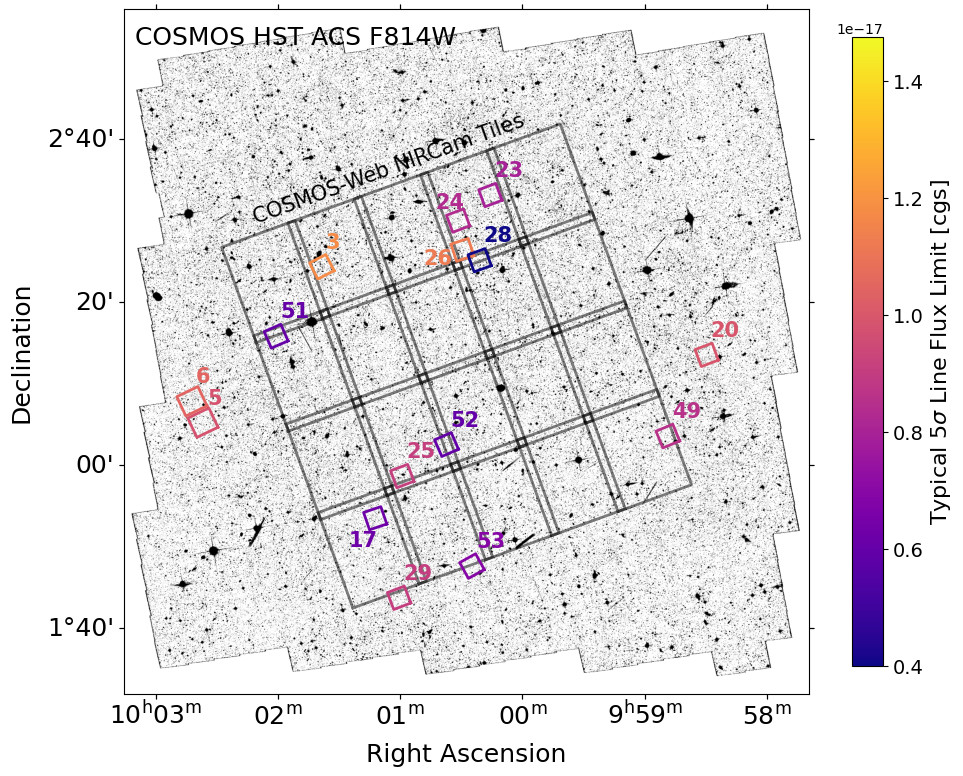

In [6]:

hdu = fits.open("mosaic_Shrink100.fits")[0]
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap='gray_r', vmin=0, vmax=0.5*hdu.data.mean())


#plt.title("COSMOS HST ACS Mosaic")


tiles = {
    # Row A
    "A1":  [(149.8703317, 2.0856512),
            (149.7198796, 2.1403395),
            (149.7908786, 2.3354095),
            (149.9413496, 2.2807163)],
    "A2":  [(150.0058959, 2.0363591),
            (149.8554506, 2.0910612),
            (149.9264667, 2.2861269),
            (150.0769300, 2.2314186)],
    "A3":  [(150.1414523, 1.9870553),
            (149.9910155, 2.0417704),
            (150.0620479, 2.2368306),
            (150.2125019, 2.1821081)],
    "A4":  [(150.2769995, 1.9377408),
            (150.1265729, 1.9924679),
            (150.1976208, 2.1875215),
            (150.3480637, 2.1327859)],
    "A5":  [(150.4125359, 1.8884166),
            (150.2621212, 1.9431545),
            (150.3331838, 2.1382005),
            (150.4836139, 2.0834528)],
    "A6":  [(149.8045087, 1.9048087),
            (149.6540746, 1.9594923),
            (149.7250552, 2.1545612),
            (149.8755087, 2.0998725)],
    "A7":  [(149.9400575, 1.8555218),
            (149.7896293, 1.9102182),
            (149.8606274, 2.1052826),
            (150.0110740, 2.0505800)],
    "A8":  [(150.0755992, 1.8062243),
            (149.9251788, 1.8609325),
            (149.9961935, 2.0559913),
            (150.1466316, 2.0012757)],
    "A9":  [(150.2111325, 1.7569171),
            (150.0607214, 1.8116361),
            (150.1317520, 2.0066883),
            (150.2821799, 1.9519607)],
    "A10": [(150.3466557, 1.7076011),
            (150.1962556, 1.7623299),
            (150.2673014, 1.9573744),
            (150.4177173, 1.9026358)],

    # Row B
    "B1":  [(150.0020274, 2.4473359),
            (149.8515406, 2.5020333),
            (149.9225757, 2.6970916),
            (150.0730806, 2.6423895)],
    "B2":  [(150.1376214, 2.3980335),
            (149.9871430, 2.4527469),
            (150.0581944, 2.6478011),
            (150.2086900, 2.5930817)],
    "B3":  [(150.2732061, 2.3487174),
            (150.1227378, 2.4034461),
            (150.1938048, 2.5984949),
            (150.3442894, 2.5437590)],
    "B4":  [(150.4087801, 2.2993886),
            (150.2583236, 2.3541315),
            (150.3294054, 2.5491739),
            (150.4798772, 2.4944226)],
    "B5":  [(150.5443418, 2.2500480),
            (150.3938989, 2.3048040),
            (150.4649946, 2.4998389),
            (150.6154520, 2.4450733)],
    "B6":  [(149.9361713, 2.2664951),
            (149.7857017, 2.3211879),
            (149.8567188, 2.5162544),
            (150.0072070, 2.4615567)],
    "B7":  [(150.0717506, 2.2171978),
            (149.9212885, 2.2719056),
            (149.9923224, 2.4669678),
            (150.1428020, 2.4122539)],
    "B8":  [(150.2073213, 2.1678878),
            (150.0568686, 2.2226097),
            (150.1279183, 2.4176665),
            (150.2783878, 2.3629373)],
    "B9":  [(150.3428821, 2.1185662),
            (150.1924404, 2.1733011),
            (150.2635052, 2.3683514),
            (150.4139629, 2.3136080)],
    "B10": [(150.4784314, 2.0692337),
            (150.3280023, 2.1239807),
            (150.3990815, 2.3190234),
            (150.5495255, 2.2642668)],
}


for name, vertices in tiles.items():
    # extract RA and Dec arrays
    ra  = np.array([v[0] for v in vertices])
    dec = np.array([v[1] for v in vertices])

    # convert to pixel coordinates
    xpix, ypix = wcs.world_to_pixel_values(ra, dec)

    # close polygon by repeating first point
    xpix = np.append(xpix, xpix[0])
    ypix = np.append(ypix, ypix[0])

    # plot polygon
    ax.plot(xpix, ypix, '-k', linewidth=2,alpha=0.5)

#centers = [
#    (150.4103959, 2.4051779),
#    (150.6536980, 2.0855800),
#]

#for (ra0, dec0) in centers:
#    plot_square(ax, wcs, ra0, dec0, side_arcsec=133, color='yellow')

#plt.show()

files = [
    "Par017_det_drz_sci.fits",
    "Par020_det_drz_sci.fits",
    "2024PASSAGE/data/Par024/DATA/Par024_det_drz_sci.fits",
    'Par029_det_drz_sci.fits',#"2024PASSAGE/data/Par029/DATA/Par029_det_drz_sci.fits",
    "2024PASSAGE/data/Par049/DATA/Par049_det_drz_sci.fits",
    "Par051_det_drz_sci.fits",
    "2024PASSAGE/data/Par053/DATA/Par053_det_drz_sci.fits",
    'Par003_det_drz_sci.fits',
    'Par005_det_drz_sci.fits',
    'Par006_det_drz_sci.fits',
    'Par023_det_drz_sci.fits',
    'Par025_det_drz_sci.fits',
    'Par026_det_drz_sci.fits',
    'Par028_det_drz_sci.fits',
    'Par052_det_drz_sci.fits',
    
]

#tiles = build_science_corner_dictionary(files)
science_edges_dict = {}
for f in files:
    science_edges_dict[f] = get_science_edges(f)
    
tiles = science_edges_dict#build_science_extreme_dictionary(files)
#tiles = build_corner_dictionary(files)
print(tiles)

import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

names=['17','20','24','29','49','51','53','3','5','6','23','25','26','28','52']
values=np.array([1.2499999999999999e-18, 1.9900000000000006e-18, 1.67e-18, 1.81e-18,1.72e-18,1.2049999999999998e-18,1.38e-18,2.3499999999999994e-18,
     1.96e-18,2.095e-18,1.595e-18,1.82e-18,2.25e-18,7.985e-19,1.19e-18])*5
#1 sigma depths
'''
Par003lines_reconciled_with_flags.dat median 2.3499999999999994e-18
Par017lines_catalog_matt_with_flags.dat median 
Par049lines_reconciled_with_flags.dat median 1.72e-18
Par053lines_reconciled_with_flags.dat median 1.38e-18
Par051lines_reconciled_with_flags.dat median 1.2049999999999998e-18
05 1.96e-18
06 2.095e-18
20 1.9900000000000006e-18
23 1.595e-18
24 1.67e-18
25 1.82e-18
26 2.25e-18#3.2949999999999994e-18
28 7.985e-19
29 1.81e-18
52 1.19e-18

'''


cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=min(values), vmax=(max(values)+0.3e-17))
c=0
for name, vertices in tiles.items():
    # extract RA and Dec arrays
    ra  = np.array([v[0] for v in vertices])
    dec = np.array([v[1] for v in vertices])

    # convert to pixel coordinates
    xpix, ypix = wcs.world_to_pixel_values(ra, dec)

    # close polygon by repeating first point
    xpix = np.append(xpix, xpix[0])
    ypix = np.append(ypix, ypix[0])

    color = cmap(norm(values[c]))
    # plot polygon
    ax.plot(xpix, ypix, '-', color=color,linewidth=2)
    #patch = Polygon(vertices, closed=True, edgecolor=color, facecolor=color, alpha=0.6)
    #ax.add_patch(patch)
    #print(xpix,ypix)
    if c==0:
        ax.text((xpix[0]+xpix[2])/2-65, (ypix[0]+ypix[2])/2-70, names[c],color=color,fontsize=15,fontweight='heavy')#, linewidth=2)
    elif c==2:
        ax.text((xpix[0]+xpix[2])/2-55, (ypix[0]+ypix[2])/2+30, names[c],color=color,fontsize=15,fontweight='heavy')#, linewidth=2)
    elif c==12:
        ax.text((xpix[0]+xpix[2])/2-95, (ypix[0]+ypix[2])/2-35, names[c],color=color,fontsize=15,fontweight='heavy')#, linewidth=2)
    else:
        ax.text((xpix[0]+xpix[2])/2+10, (ypix[0]+ypix[2])/2+45, names[c],color=color,fontsize=15,fontweight='heavy')#, linewidth=2)
    c+=1

ax.text(650,1290,'COSMOS-Web NIRCam Tiles',fontsize=15,horizontalalignment='center', verticalalignment='center', rotation=20)#750,1310
ax.text(420,1610,'COSMOS HST ACS F814W',fontsize=18,horizontalalignment='center', verticalalignment='center')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label(r'Typical 5$\sigma$ Line Flux Limit [cgs]', fontsize=16)      # Colorbar label
cbar.ax.tick_params(labelsize=14) 

ax.set_xlabel("Right Ascension",fontsize=18)
ax.set_ylabel("Declination",fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18) 

plt.tight_layout()
plt.show()



In [69]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import poisson
from astropy.io import ascii
from sklearn.linear_model import LinearRegression
#import seaborn as sns
import pandas as pd
from astropy.table import Table
from astropy.io import fits
from scipy.odr import *
import os
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
def match_catalogs(samp_x, samp_y, cat_x, cat_y, max_sep=0.1*u.arcsec):
    if not isinstance(max_sep, astropy.units.quantity.Quantity):
        max_sep = max_sep * u.degree
    sample = SkyCoord(ra=samp_x*u.degree, dec=samp_y*u.degree)
    catalog = SkyCoord(ra=cat_x*u.degree, dec=cat_y*u.degree)
    idx, d2d, d3d = sample.match_to_catalog_sky(catalog)
    samp_sel = d2d < max_sep
    return samp_sel, idx
#import seaborn as sns
from scipy import stats

In [70]:
file_path_class1 = 'Par028lines_reconciled_with_flags.dat'
df28 = pd.read_csv(file_path_class1,header=0, sep='\s+')#'ha_6565_flux',
df28

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/v1/3zv2nkl92xnd00kcpp2yb_580000gn/T/ipykernel_25855/2903163825.py:2: SyntaxWarning: invalid escape sequence '\s'
  df28 = pd.read_csv(file_path_class1,header=0, sep='\s+')#'ha_6565_flux',


,objid,redshift,redshift_error,ra_obj,dec_obj,f140w_mag,a_image_obj,b_image_obj,snr_tot_others,chisq,...,he1_5875_ratio,he1_5875_contam,snr_Lya,snr_OII,snr_OIII,snr_Hb,snr_Ha,snr_Pb,snr_SIII,emline_flag
0,4,1.74457,0.00000,150.098489,2.395111,30.02,3.313,2.407,9.64,4.61,...,0.0,0,-1.0,0.000000,1.800720,-1.000000,11.496063,-1.0,-1.0,4
1,18,3.18420,0.00104,150.097108,2.396032,30.38,2.199,2.054,13.31,5.91,...,0.0,0,-1.0,1.570058,13.340935,1.944444,-1.000000,-1.0,-1.0,3
2,53,1.87000,0.00039,150.096164,2.396819,26.94,12.629,4.410,18.24,5.49,...,0.0,0,-1.0,8.612500,25.000000,4.541667,10.422374,-1.0,-1.0,1
3,32,3.49936,0.00000,150.097836,2.396515,28.29,7.468,3.525,4.56,6.80,...,0.0,0,-1.0,-1.000000,-1.000000,0.362595,-1.000000,-1.0,-1.0,9
4,86,1.86508,0.00000,150.099853,2.398299,27.38,7.817,4.268,7.17,5.47,...,0.0,0,-1.0,4.661836,11.687500,3.141844,9.541284,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,1807,2.19207,0.00067,150.071519,2.417384,29.11,3.514,2.732,8.52,6.00,...,0.0,0,-1.0,4.623955,12.193548,2.340541,1.985915,-1.0,-1.0,2
284,2317,3.13699,0.00066,150.071107,2.422020,28.48,4.077,3.233,14.43,6.64,...,0.0,0,-1.0,0.564948,17.812500,1.749460,-1.000000,-1.0,-1.0,3
285,2319,2.09056,0.00159,150.071326,2.422132,28.58,4.886,3.106,9.75,8.41,...,0.0,0,-1.0,0.000000,1.551181,2.568345,11.960784,-1.0,-1.0,2
286,1661,1.53912,0.00000,150.095002,2.416386,28.42,3.391,3.028,8.37,8.95,...,0.0,0,-1.0,-1.000000,8.671587,6.351085,-1.000000,-1.0,-1.0,1


In [71]:
file_path_class1 = 'Par026lines_reconciled_with_flags.dat'
df26 = pd.read_csv(file_path_class1,header=0, sep='\s+')#'ha_6565_flux',
df26

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/v1/3zv2nkl92xnd00kcpp2yb_580000gn/T/ipykernel_25855/1597802570.py:2: SyntaxWarning: invalid escape sequence '\s'
  df26 = pd.read_csv(file_path_class1,header=0, sep='\s+')#'ha_6565_flux',


,objid,redshift,redshift_error,ra_obj,dec_obj,f140w_mag,a_image_obj,b_image_obj,snr_tot_others,chisq,...,he1_5875_ratio,he1_5875_contam,snr_Lya,snr_OII,snr_OIII,snr_Hb,snr_Ha,snr_Pb,snr_SIII,emline_flag
0,20,0.83954,0.00119,150.132151,2.417949,26.79,2.278,1.867,5.81,9.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,1.25407,0.00132,150.130547,2.418153,27.69,2.204,1.279,6.19,12.92,...,0.0,0.0,-1.0,-1.000000,7.772358,2.601726,3.495630,-1.000000,-1.000000,2.0
2,34,1.79873,0.00000,150.131208,2.418556,24.19,9.849,3.671,12.91,96.41,...,0.0,0.0,-1.0,0.423077,12.921615,0.033728,-1.000000,-1.000000,-1.000000,3.0
3,38,1.79528,0.00000,150.130996,2.418756,22.99,7.596,4.775,21.08,15.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52,1.10798,0.00000,150.130698,2.419200,22.19,17.680,5.873,4.67,20.12,...,0.0,0.0,-1.0,-1.000000,3.369668,0.775824,5.404255,-1.000000,-1.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,3550,0.24983,0.00042,150.118840,2.456195,26.38,2.348,1.945,3.37,16.41,...,0.0,0.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,2.742308,3.365201,4.0
156,3566,2.19202,0.00000,150.111143,2.456448,26.00,3.925,2.203,6.42,15.55,...,0.0,0.0,-1.0,0.461150,6.428571,1.431507,-1.000000,-1.000000,-1.000000,3.0
157,3595,2.19244,0.00049,150.111807,2.456957,25.68,3.492,2.262,16.13,10.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,3612,2.20299,0.00126,150.111722,2.457258,24.85,3.674,2.834,7.14,14.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
samp_x = np.array(df28['ra_obj'])#.data
samp_y = np.array(df28['dec_obj'])#.data
cat_x = np.array(df26['ra_obj'])#hdu[1].data['ra      ']#dat['ra      ']#.data
cat_y = np.array(df26['dec_obj'])#hdu[1].data['dec     ']#dat['dec     ']#.data
#print(samp_x)

sel_samp, idx = match_catalogs(samp_x, samp_y, cat_x, cat_y,max_sep=0.1*u.arcsec)

tt = np.ones(shape=(len(np.array(df28['ra_obj'])),)) * (-1)
tt[sel_samp] = np.array(df26['ra_obj'])[idx[sel_samp]]

tt2 = np.ones(shape=(len(np.array(df28['dec_obj'])),)) * (-1)
tt2[sel_samp] = np.array(df26['dec_obj'])[idx[sel_samp]]

tt3 = np.ones(shape=(len(np.array(df28['dec_obj'])),)) * (-1)
tt3[sel_samp] = np.array(df26['redshift'])[idx[sel_samp]]

tt4 = np.ones(shape=(len(np.array(df28['dec_obj'])),)) * (-1)
tt4[sel_samp] = np.array(df26['objid'])[idx[sel_samp]]

tt5 = np.ones(shape=(len(np.array(df28['dec_obj'])),)) * (-1)
tt5[sel_samp] = np.array(df26['emline_flag'])[idx[sel_samp]]

df28['par26ra']=tt
df28['par26dec']=tt2
df28['par26z']=tt3
df28['par26id']=tt4
df28['par26flag']=tt5
df28[df28['par26ra']>0]



,objid,redshift,redshift_error,ra_obj,dec_obj,f140w_mag,a_image_obj,b_image_obj,snr_tot_others,chisq,...,snr_Hb,snr_Ha,snr_Pb,snr_SIII,emline_flag,par26ra,par26dec,par26z,par26id,par26flag
228,3041,0.69317,0.00012,150.101416,2.430229,26.56,7.465,4.996,17.7,14.72,...,-1.0,18.715596,1.351351,14.566929,1,150.101415,2.430229,0.69429,801.0,NaN


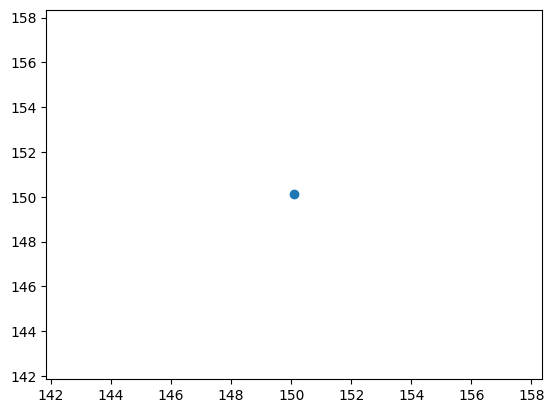

In [74]:
plt.scatter(df28['ra_obj'][df28['par26ra']>0],df28['par26ra'][df28['par26ra']>0])

In [83]:
h26=fits.open('spec1D26/Par026_00801.spec1D.fits')
h26.info()

Filename: spec1D26/Par026_00801.spec1D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  F115W         1 BinTableHDU     40   79R x 9C   [D, D, D, D, D, D, D, K, D]   
  2  F150W         1 BinTableHDU     33   99R x 9C   [D, D, D, D, D, D, D, K, D]   
  3  F115W       288.0 BinTableHDU     43   79R x 9C   [D, D, D, D, D, D, D, K, D]   
  4  F150W       288.0 BinTableHDU     36   99R x 9C   [D, D, D, D, D, D, D, K, D]   


In [77]:
h28=fits.open('spec1D/Par028_03041.spec1D.fits')
h28[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   72 / length of dimension 1                          
NAXIS2  =                   79 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    9 / number of table fields                         
GRISM   = 'F115W   '           / Grism name                                     
BIN     =                    1 / Spectrum binning factor                        
NEXP    =                   27 / Number of exposures                            
FILE0001= 'jw01571228001_03201_00001_nis_rate.fits' / Parent file               
FILE0002= 'jw01571228001_032

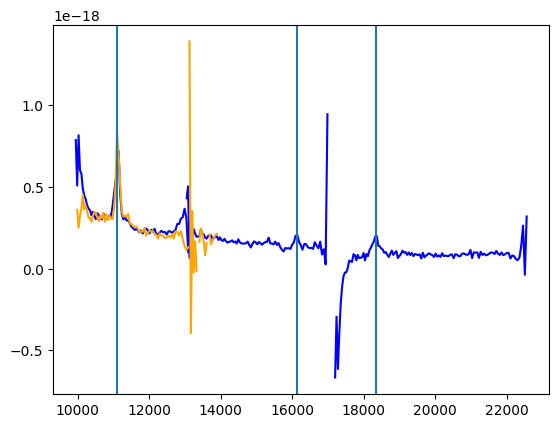

In [90]:
plt.plot(h28[1].data['wave'],h28[1].data['flux'],color='b')
plt.plot(h28[2].data['wave'],h28[2].data['flux'],color='b')
plt.plot(h28[3].data['wave'],h28[3].data['flux'],color='b')
plt.plot(h26[1].data['wave'],h26[1].data['flux'],color='orange')
plt.plot(h26[2].data['wave'],h26[2].data['flux'],color='orange')
plt.axvline(6565*(1+0.69317))
plt.axvline(9533*(1+0.69317))
plt.axvline(10832.9*(1+0.69317))